# Bibliotecas

In [674]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Pré processamento
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Armazenamento dos modelos
import json
import pickle

# Seleção de variáveis
from boruta import BorutaPy

# Modelos
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor


# Metricas dos modelos
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Configurações de página
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

sns.set(style="white")

warnings.filterwarnings('ignore')

#### Salvando as bibliotecas utilizadas

In [675]:
%%writefile "/content/drive/MyDrive/Projeto Indicium/requirements.txt"
pandas==1.5.3
numpy==1.5.3
matplotlib==3.7.1
seaborn==0.13.1
plotly==5.15.0
scikit-learn==1.2.2
boruta==0.3
xgboost==2.0.3

Overwriting /content/drive/MyDrive/Projeto Indicium/requirements.txt


# Conhecendo a base de dados

## Carregando a base

In [676]:
#df = pd.read_csv('teste_indicium_precificacao.csv')
df = pd.read_csv('/content/drive/MyDrive/Projeto Indicium/teste_indicium_precificacao.csv')

## Pré-visualização

In [677]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## Verificando os tipos das colunas

In [678]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

## Adequando o tipo das colunas

In [679]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'],yearfirst=True)

In [680]:
df['id'] = df['id'].astype(str)
df['host_id'] = df['host_id'].astype(str)

In [681]:
df.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365


### Conferindo as adequações

In [682]:
print(df.dtypes)

id                                       object
nome                                     object
host_id                                  object
host_name                                object
bairro_group                             object
bairro                                   object
latitude                                float64
longitude                               float64
room_type                                object
price                                     int64
minimo_noites                             int64
numero_de_reviews                         int64
ultima_review                    datetime64[ns]
reviews_por_mes                         float64
calculado_host_listings_count             int64
disponibilidade_365                       int64
dtype: object


## EDA e Tratamento Inicial das Variáveis

In [683]:
# Lista das variáveis numericas
num_vars = df.select_dtypes(include=['float','int'])
num_vars = num_vars.columns
num_vars = num_vars[2:]

### Estatísticas descritivas

In [684]:
df[num_vars].describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Vizualizando a distribuição dos dados

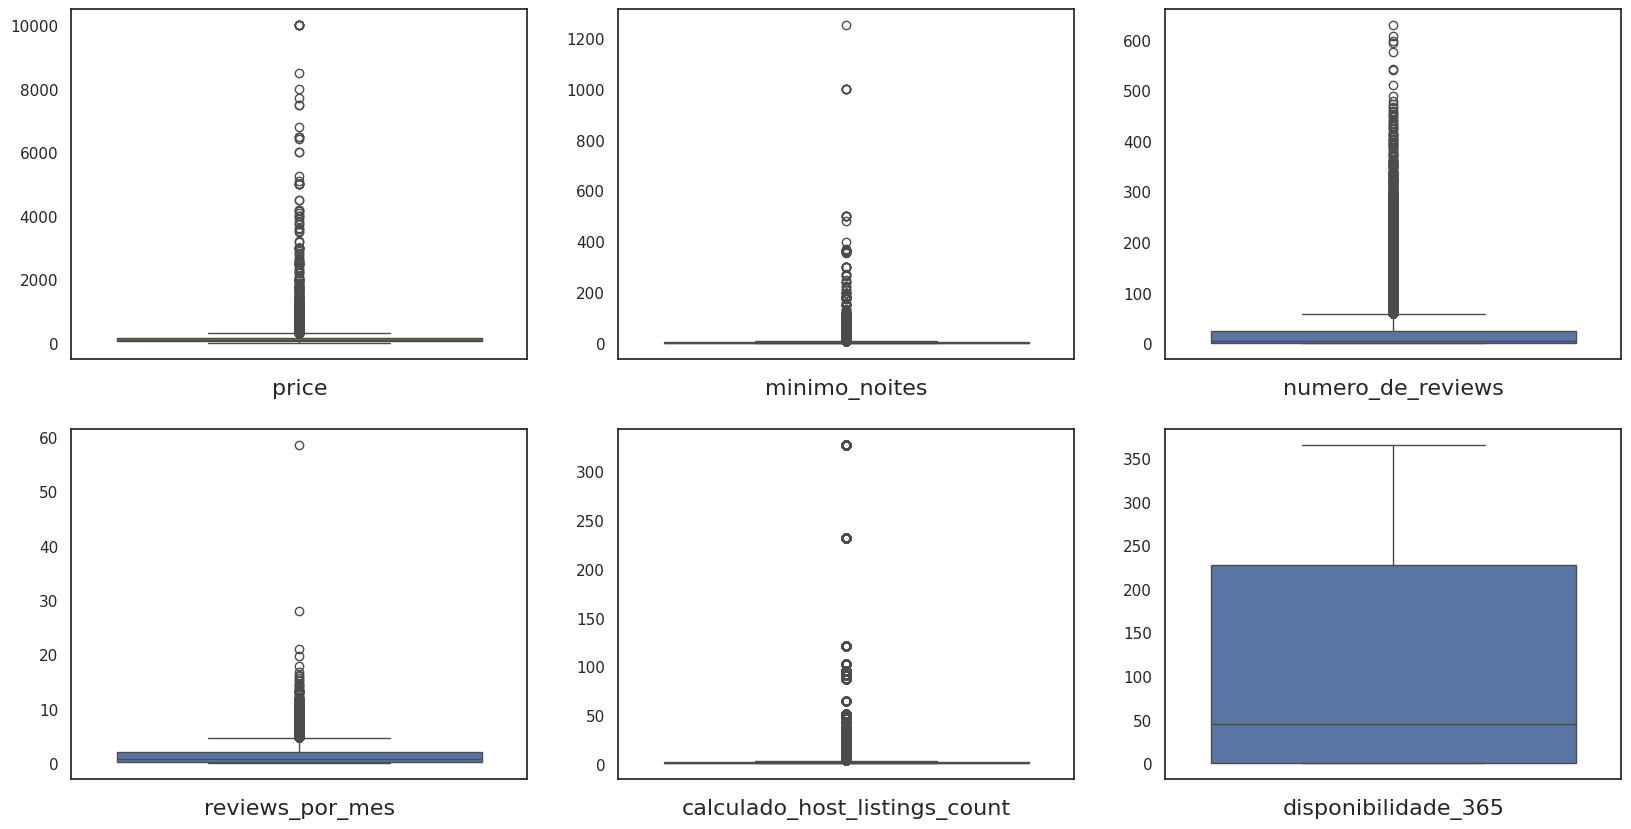

In [685]:
for indice,var in enumerate(num_vars):
    plt.subplot(2,3,indice+1)
    ax = sns.boxplot(df[var])
    ax.figure.set_size_inches(20,10)
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('')
    ax

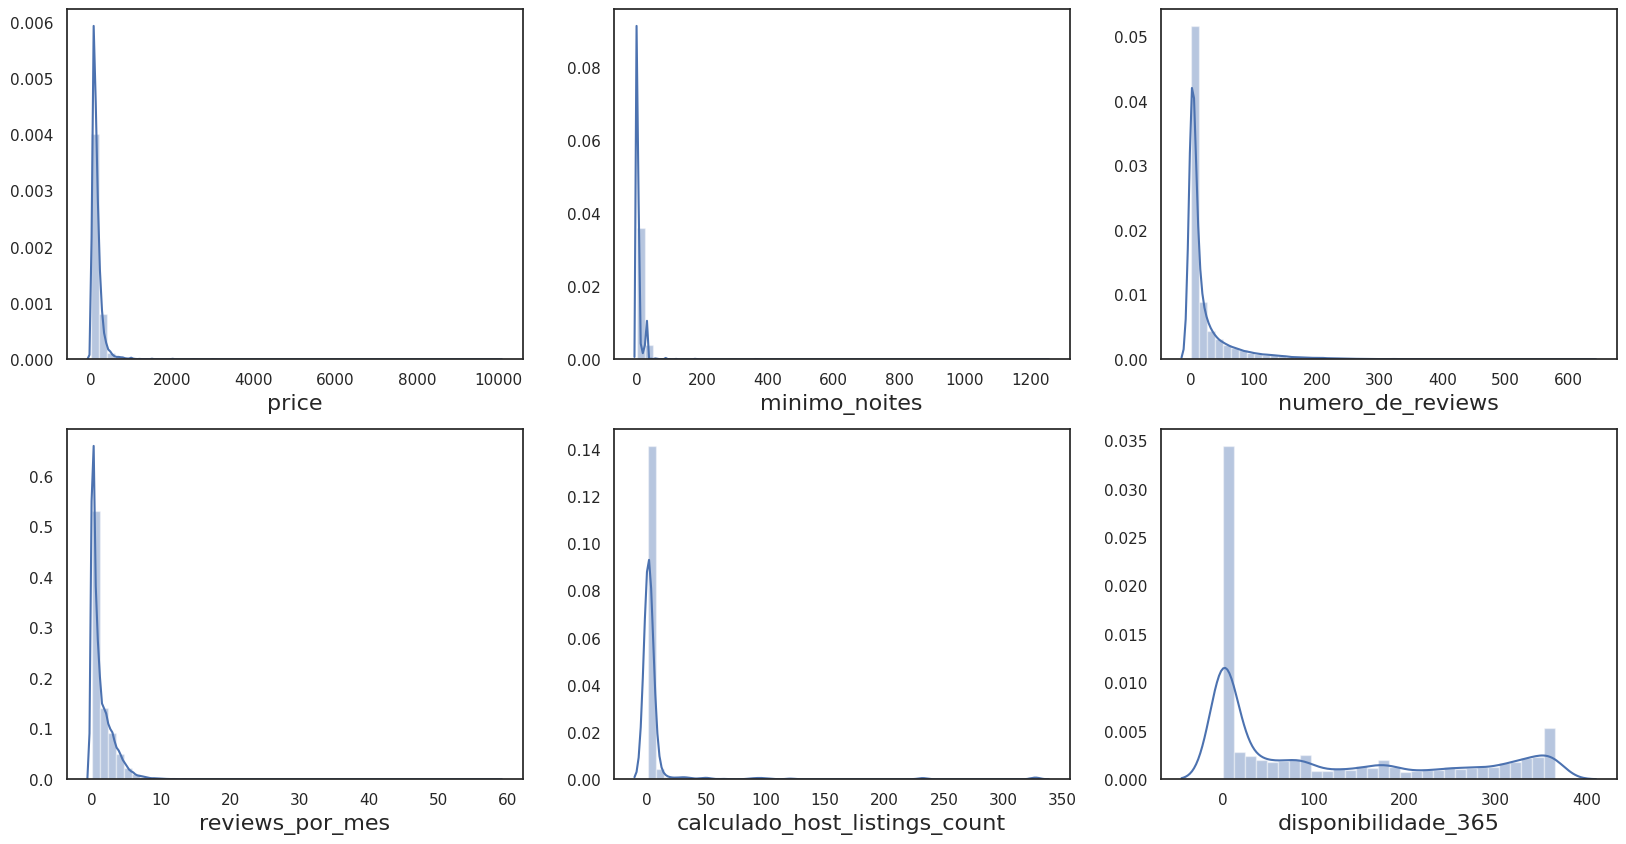

In [686]:
for indice,var in enumerate(num_vars):
    plt.subplot(2,3,indice+1)
    ax = sns.distplot(df[var])
    ax.figure.set_size_inches(20,10)
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('')
    ax

In [687]:
# Ajustando o tamanho dos pontos com base no preço para melhor visualização
df['size'] = df['price'] / df['price'].max() * 150
df['size'] = df['size'].apply(lambda x: max(x, 5))  # Garantindo um tamanho mínimo para visibilidade

# Criando o mapa
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        color="room_type",  # Cor diferenciada por tipo de quarto
                        size="size",  # Tamanho do ponto baseado no preço ajustado
                        color_continuous_scale=px.colors.cyclical.IceFire,  # Escala de cor
                        size_max=15,
                        zoom=10,
                        hover_data=['price','numero_de_reviews','disponibilidade_365','calculado_host_listings_count'],
                        mapbox_style="carto-positron",
                        title="Mapa de Listagens por Preço e Tipo de Quarto")
fig.update_layout(height = 600,width=1200, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()


Baseando-se nas estatísticas descritivas, na análise gráfica e visual do mapa, identificamos que nossa base de dados contém valores com um desvio significativo em relação ao conjunto dos dados. Esses pontos, muito provavelmente outliers, podem representar erros ou anomalias. Para assegurar uma representação mais fiel e precisa dos dados reais, é essencial realizar o tratamento desses valores. A seguir, procederemos com as etapas necessárias para ajustar ou remover esses outliers, visando melhorar a qualidade e a representatividade dos nossos dados.

In [688]:
# Fazendo uma copia da base sem tratamento dos outliers
df_sem_tratamento = df.copy()

In [689]:
def tratamento_outliers(df, coluna):
    # Cálculo dos quartis
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)

    # Cálculo da distância entre quartis
    IQR = Q3 - Q1

    # Definindo o limite máximo para a remoção dos ouliers
    limite_superior = float(Q3 + 1.5 * IQR)

    # Substituindo os valores outliers por nulos
    df.loc[df[coluna]>limite_superior,coluna] = np.nan

    # Imputando novos valores com base nas médias por tipo de quarto e bairro
    df.loc[df[coluna].isna(),coluna] = df.groupby(['bairro_group','room_type'])[coluna].transform('mean')

# Aplicando a função a minhas variáveis
for coluna in num_vars:
    print(coluna)
    tratamento_outliers(df,coluna)
    print(df[coluna].isna().sum())

price
0
minimo_noites
0
numero_de_reviews
0
reviews_por_mes
0
calculado_host_listings_count
0
disponibilidade_365
0


In [690]:
# Removendo as linhas que apresentam price igual a zero
df = df[df['price']>0]

### Reavaliando as variáveis após o tratamento dos outliers

In [691]:
df[num_vars].describe()

,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48883.000000,48883.000000,48883.000000,48883.000000,48883.000000,48883.000000
mean,122.544516,2.716553,9.699029,1.128689,1.299068,112.774339
std,67.236831,1.731454,12.519423,1.044036,0.546218,131.623674
min,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.280000,1.000000,0.000000
50%,104.000000,2.000000,5.000000,0.988577,1.000000,45.000000
75%,170.000000,3.000000,11.946857,1.418297,1.418119,227.000000
max,334.000000,11.000000,58.000000,4.760000,3.000000,365.000000


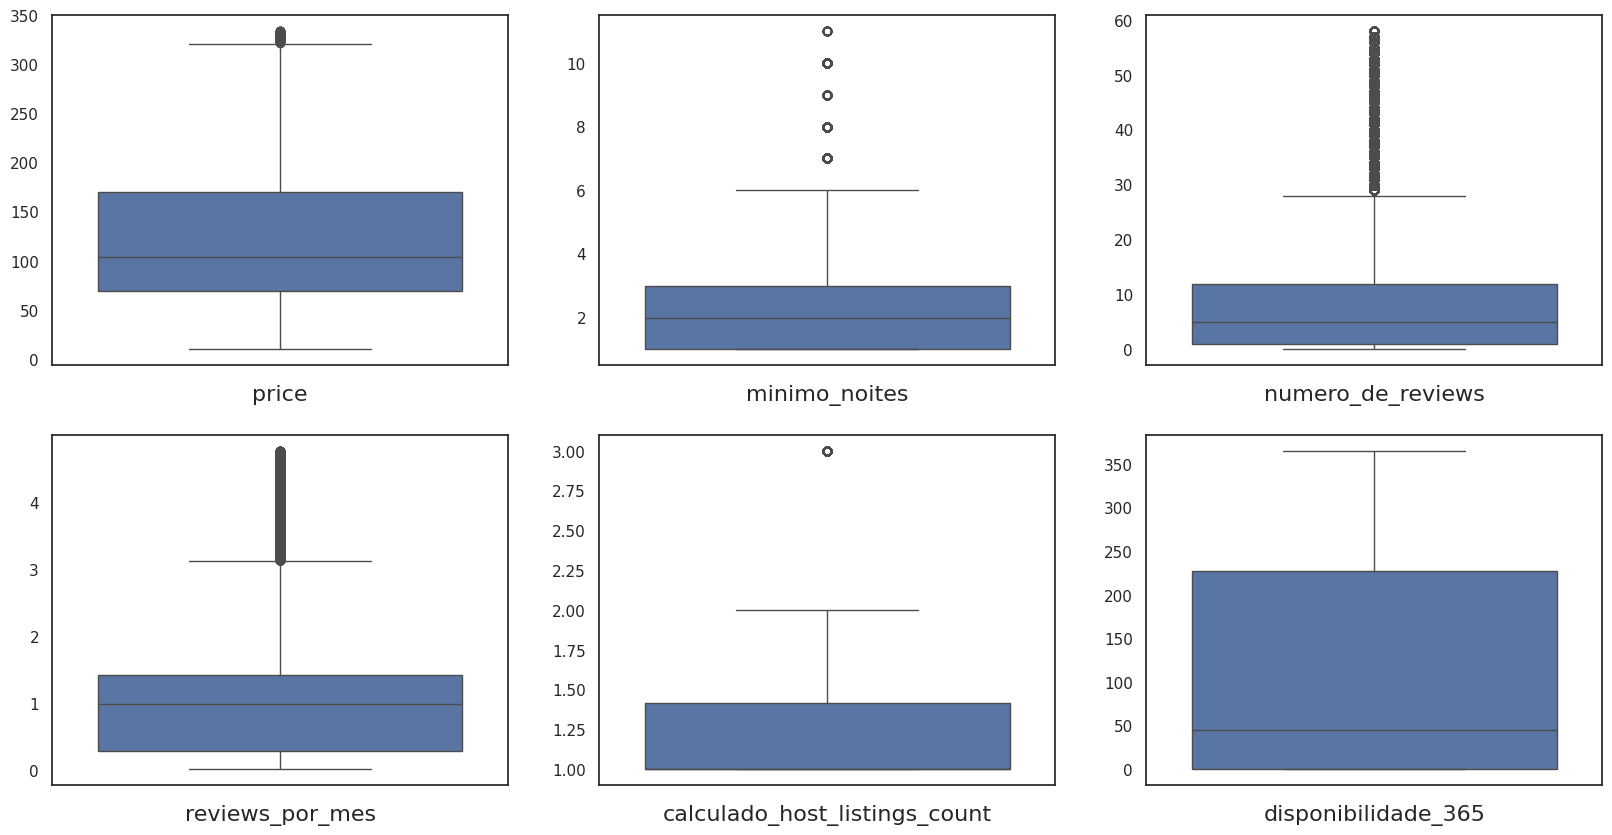

In [692]:
for indice,var in enumerate(num_vars):
    plt.subplot(2,3,indice+1)
    ax = sns.boxplot(df[var])
    ax.figure.set_size_inches(20,10)
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('')
    ax

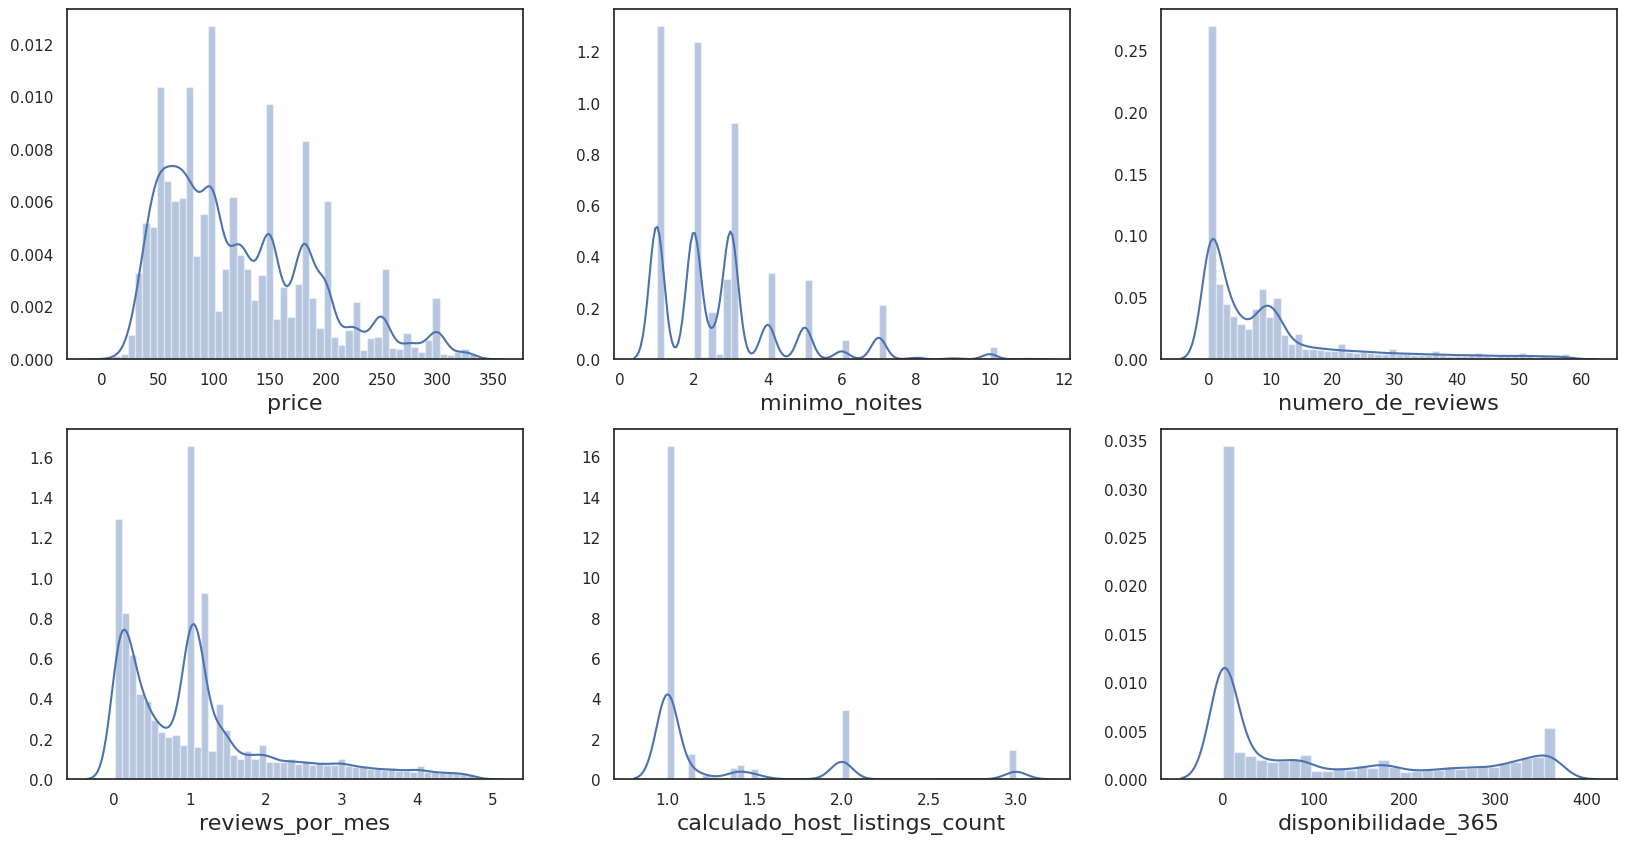

In [693]:
for indice,var in enumerate(num_vars):
    plt.subplot(2,3,indice+1)
    ax = sns.distplot(df[var])
    ax.figure.set_size_inches(20,10)
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('')
    ax

In [694]:
# Ajustando o tamanho dos pontos com base no preço para melhor visualização
df['size'] = df['price'] / df['price'].max() * 30
df['size'] = df['size'].apply(lambda x: max(x, 5))  # Garantindo um tamanho mínimo para visibilidade

# Criando o mapa
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        color="room_type",  # Cor diferenciada por tipo de quarto
                        size="size",  # Tamanho do ponto baseado no preço ajustado
                        color_continuous_scale=px.colors.cyclical.IceFire,  # Escala de cor
                        size_max=15,
                        zoom=10,
                        hover_data=['price','numero_de_reviews','disponibilidade_365','calculado_host_listings_count'],
                        mapbox_style="carto-positron",
                        title="Mapa de imóveis por Tipo de quarto")
fig.update_layout(height = 600,width=1200, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.


Após o tratamento dos dados discrepantes, a base de dados apresenta maior uniformidade e representatividade da realidade, possibilitando análises mais precisas e confiáveis.

## EDA - Base após tratamento de Outliers

### Avaliação dos imóveis por região e tipo de acomodações oferecidas

In [695]:
# Ajustando o tamanho dos pontos com base no preço para melhor visualização
df['size'] = df['price'] / df['price'].max() * 300
df['size'] = df['size'].apply(lambda x: max(x, 5))  # Garantindo um tamanho mínimo para visibilidade

# Criando o mapa
fig = px.scatter_mapbox(df,
                        lat="latitude",
                        lon="longitude",
                        color="bairro_group",  # Cor diferenciada por tipo de quarto
                        size="size",  # Tamanho do ponto baseado no preço ajustado
                        color_continuous_scale=px.colors.cyclical.IceFire,  # Escala de cor
                        size_max=15,
                        zoom=10,
                        hover_data=['price'],
                        mapbox_style="carto-positron",
                        title="Mapa de imóveis por Região")
fig.update_layout(height = 600,width=1200, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Distribuição de preço por região

<Axes: title={'center': 'Boxplots - Preços por Região'}, xlabel='Região', ylabel='Preço'>

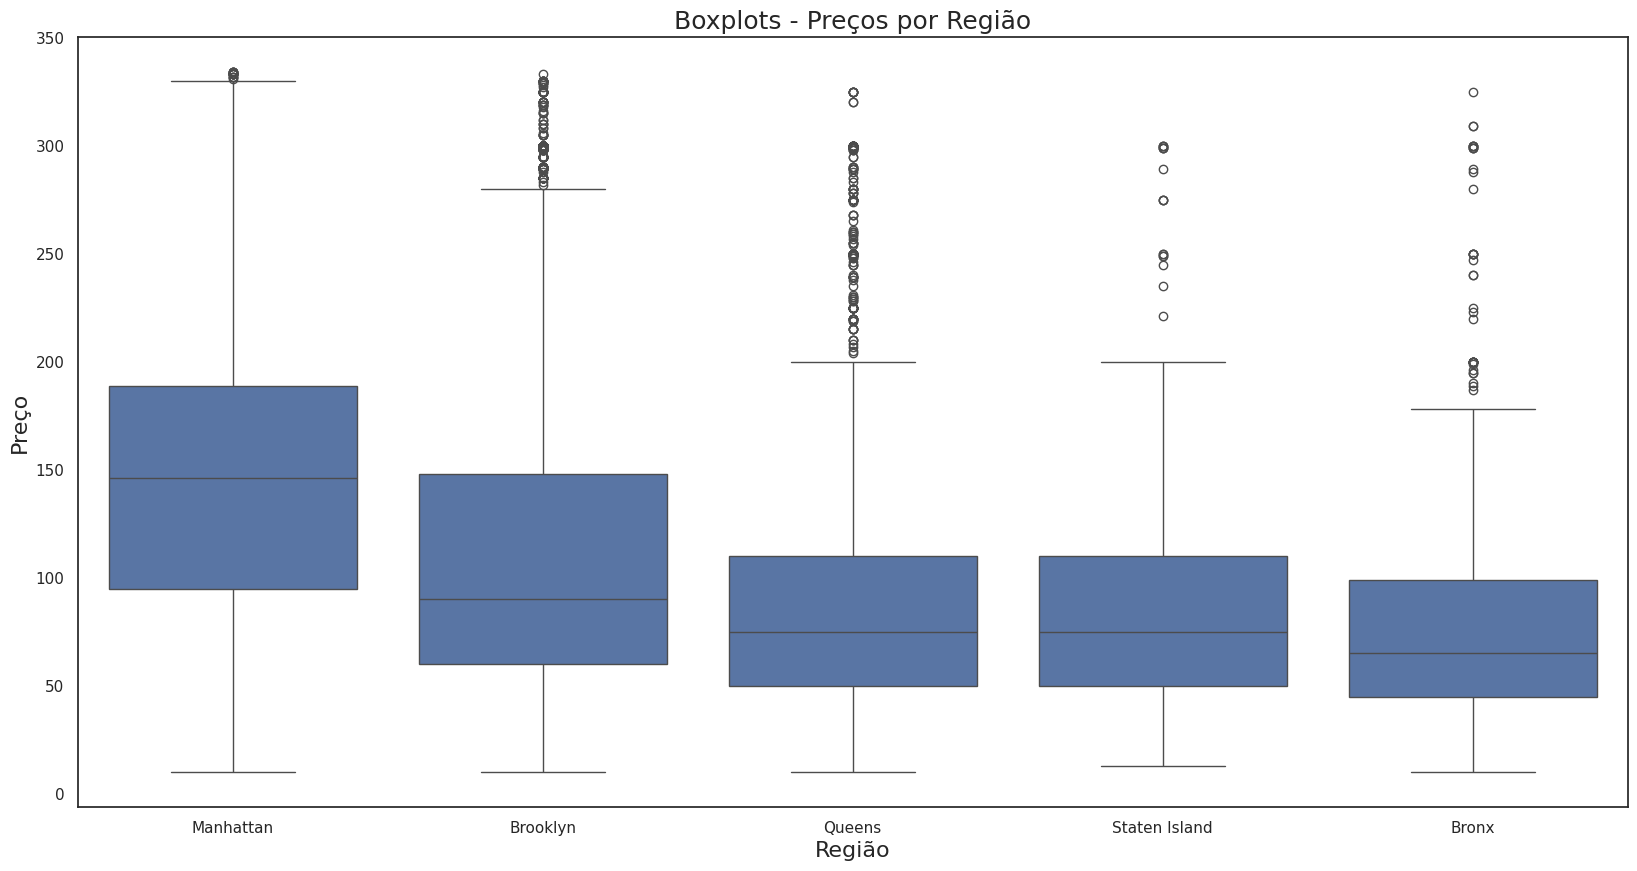

In [696]:
ax = sns.boxplot(x=df['bairro_group'],y=df['price'])
ax.figure.set_size_inches(20,10)
ax.set_title('Boxplots - Preços por Região',fontsize=18)
ax.set_xlabel('Região',fontsize=16)
ax.set_ylabel('Preço',fontsize=16)
ax

In [697]:
df.groupby('bairro_group')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
bairro_group,,,,,,,,
Bronx,1090.0,77.858501,46.825522,10.0,45.0,65.0,99.00000,325.0
Brooklyn,20094.0,106.920725,60.344963,10.0,60.0,90.0,148.20208,333.0
Manhattan,21660.0,148.534415,67.863796,10.0,95.0,146.0,189.00000,334.0
Queens,5666.0,89.343035,53.315748,10.0,50.0,75.0,110.00000,325.0
Staten Island,373.0,89.918805,57.263090,13.0,50.0,75.0,110.00000,300.0


Podemos notar que a maioria das acomodações estão localizadas nos grupos de Manhattan e Brooklyn, seguidos por Queens, Bronx e Staten Island. Além de concentrarem o maior número de acomodações, Manhattan e Brooklyn se destacam pela valorização superior de seus imóveis quando comparados aos outros grupos. Desta forma podemos encontrar ótimas oportunidades de investimentos nessas regiões que apresentam uma valorização acima da médias.

### Avaliando os preços por tipo de acomodação

<Axes: title={'center': 'Boxplots - Preços por Tipo de Acomodação'}, xlabel='Tipo de Acomodação', ylabel='Preço'>

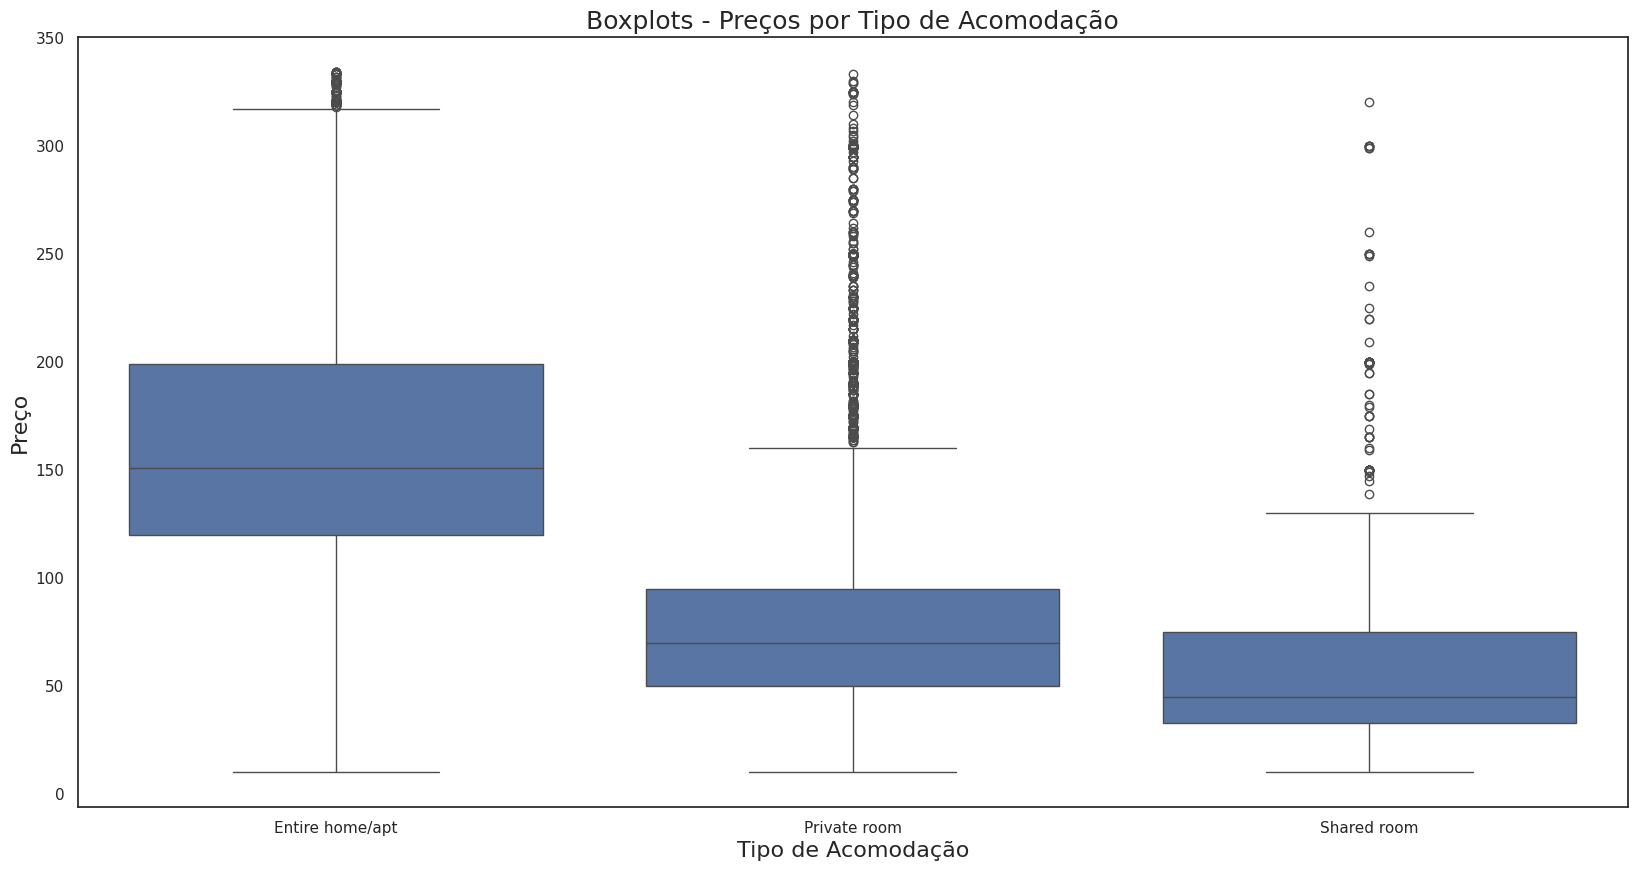

In [698]:
ax = sns.boxplot(x=df['room_type'],y=df['price'])
ax.figure.set_size_inches(20,10)
ax.set_title('Boxplots - Preços por Tipo de Acomodação',fontsize=18)
ax.set_xlabel('Tipo de Acomodação',fontsize=16)
ax.set_ylabel('Preço',fontsize=16)
ax

In [699]:
df.groupby('room_type')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25407.0,163.493116,60.315725,10.0,120.0,151.0,199.0,334.0
Private room,22318.0,79.197402,40.904726,10.0,50.0,70.0,95.0,333.0
Shared room,1158.0,59.539191,42.440451,10.0,33.0,45.0,75.0,320.0


A avaliação das acomodações com base no tipo revela que a categoria 'Entire home/apt' se sobressai em comparação com as outras duas modalidades, 'Private room' e 'Shared room'. Isso evidencia uma preferência por acomodações que oferecem privacidade total e acesso exclusivo ao imóvel. Tal preferência se reflete não apenas no volume de ofertas disponíveis nessa categoria, mas também na valorização superior desses imóveis. Esta tendência indica que os investidores podem encontrar grande valor ao focar nesse segmento.

### Avaliação dos tipos de acomodações e grupo de bairro

<Axes: title={'center': 'Boxplots - Preços por Região/Tipo de Acomodação'}, xlabel='Região', ylabel='Preço'>

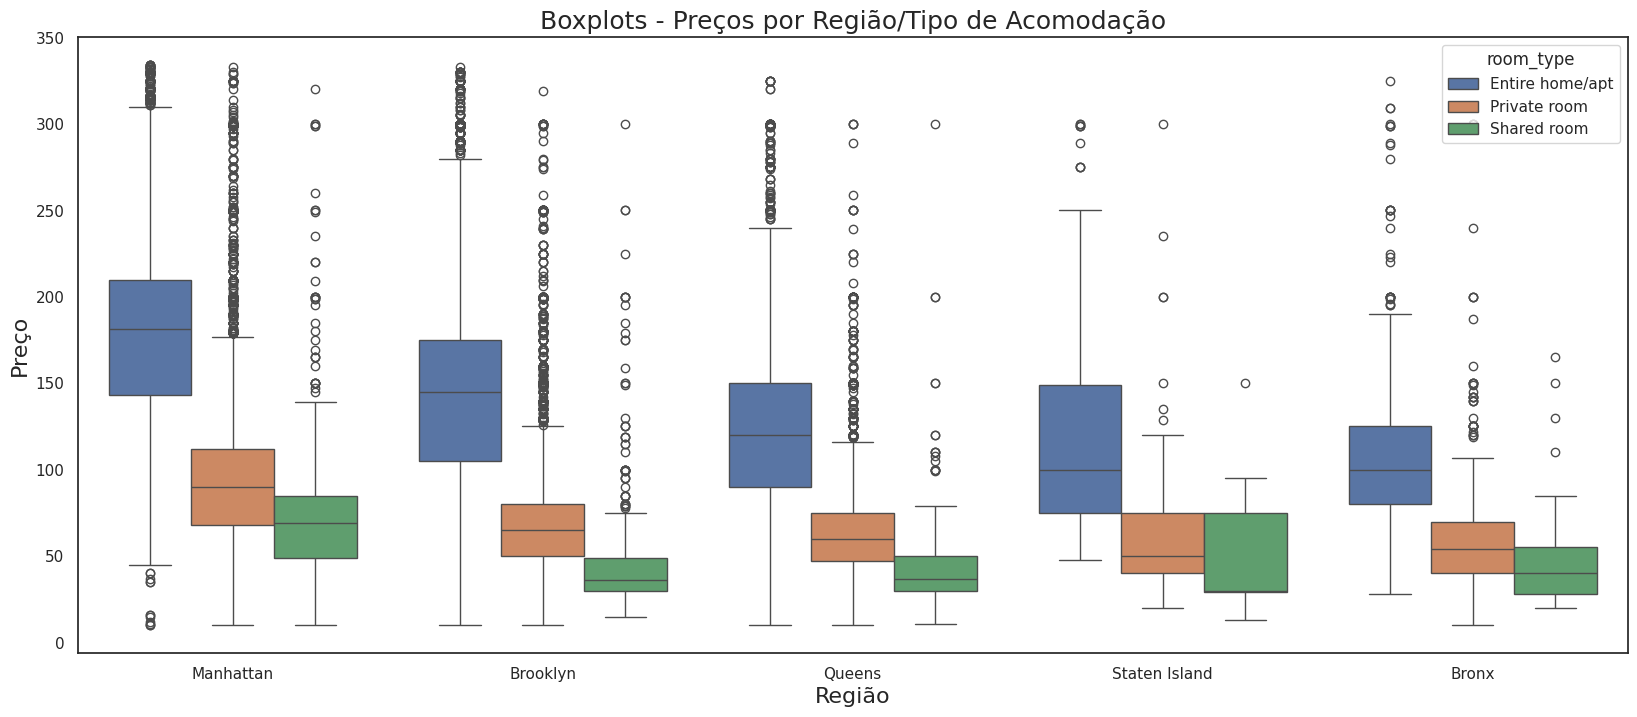

In [700]:
ax = sns.boxplot(x=df['bairro_group'],y=df['price'],hue=df['room_type'])
ax.figure.set_size_inches(20,8)
ax.set_title('Boxplots - Preços por Região/Tipo de Acomodação',fontsize=18)
ax.set_xlabel('Região',fontsize=16)
ax.set_ylabel('Preço',fontsize=16)
ax

In [701]:
# Quantidade de cada tipo de acomodação em cada grupo de bairro
pd.crosstab(df['bairro_group'],df['room_type'],margins=True)

room_type,Entire home/apt,Private room,Shared room,All
bairro_group,,,,
Bronx,379,651,60,1090
Brooklyn,9558,10125,411,20094
Manhattan,13198,7982,480,21660
Queens,2096,3372,198,5666
Staten Island,176,188,9,373
All,25407,22318,1158,48883


In [702]:
# Percentual de cada tipo de acomodação em cada grupo de bairro pelo Total de imóveis
pd.crosstab(df['bairro_group'],df['room_type'],normalize=True,margins=True)*100

room_type,Entire home/apt,Private room,Shared room,All
bairro_group,,,,
Bronx,0.775321,1.331751,0.122742,2.229814
Brooklyn,19.552810,20.712722,0.840783,41.106315
Manhattan,26.999161,16.328785,0.981936,44.309883
Queens,4.287789,6.898104,0.405049,11.590942
Staten Island,0.360043,0.384592,0.018411,0.763046
All,51.975124,45.655954,2.368922,100.000000


In [703]:
# Percentual do total de tipo de acomodação por Grupo de bairro
pd.crosstab(df['bairro_group'],df['room_type'],normalize='columns',margins=True)*100

room_type,Entire home/apt,Private room,Shared room,All
bairro_group,,,,
Bronx,1.491715,2.916928,5.181347,2.229814
Brooklyn,37.619554,45.366968,35.492228,41.106315
Manhattan,51.946314,35.764853,41.450777,44.309883
Queens,8.249695,15.108881,17.098446,11.590942
Staten Island,0.692722,0.842369,0.777202,0.763046


Levando em consideração as tabelas apresentadas, podemos observar que Manhattan e Brooklyn são os bairros com a maior oferta de acomodações em Nova York, concentrando 44% e 41% do total de imóveis listados, respectivamente. Enquanto Manhattan tem uma predominância de "Entire home/apt" que compõe 52% do tipo de acomodação na cidade, Brooklyn lidera com 45% dos "Private room" disponíveis. Os "Shared room", apesar de serem menos comuns, têm uma distribuição mais equitativa entre os dois bairros, com Manhattan abrigando 42% e Brooklyn 36% desse segmento. As demais regiões, como Queens, Bronx e Staten Island, oferecem uma contribuição menor, completando o restante do mercado de aluguéis.

In [704]:
# Média de preço por tipo de acomodação e grupo de bairro
pd.crosstab(df['bairro_group'],df['room_type'],values=df['price'],aggfunc='mean')

room_type,Entire home/apt,Private room,Shared room
bairro_group,,,
Bronx,112.195592,60.688760,47.254237
Brooklyn,148.217586,70.317264,48.270251
Manhattan,181.702362,98.057700,75.939785
Queens,131.328388,65.732319,46.989691
Staten Island,121.089286,62.292553,57.444444


Manhattan é o bairro com os preços médios mais altos em todas as categorias de acomodações. O Bronx oferece as opções mais acessíveis para 'Entire home/apt'. Staten Island tem preços moderados em comparação com os outros bairros, mas os quartos compartilhados são relativamente mais caros que em Queens e Bronx. Brooklyn apresenta uma faixa de preço médio para 'Entire home/apt' e quartos privados, mas os preços de quartos compartilhados estão próximos aos de Manhattan. ​

# Respondendo algumas questões:


## 2. Responda também às seguintes perguntas:

### a. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

R: Como apresentado na análise podemos notar que as regiões com maior valorização são Manhattan e Brooklyn, desta forma são regiões que podem revelar ótimas oportunidades de negócio com um alto retorno sobre o investimento.

### b. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?



In [705]:
matriz_corr = df[['price','minimo_noites','disponibilidade_365']].corr()
matriz_corr

,price,minimo_noites,disponibilidade_365
price,1.000000,0.074168,0.076434
minimo_noites,0.074168,1.000000,-0.078818
disponibilidade_365,0.076434,-0.078818,1.000000


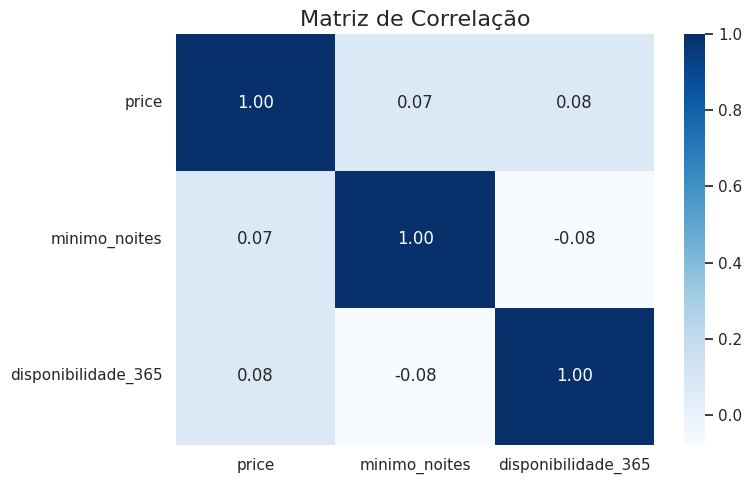

In [706]:
ax = sns.heatmap(matriz_corr, cmap= 'Blues', annot=True, fmt=".2f")
ax.figure.set_size_inches(8,5)
ax.set_title('Matriz de Correlação',fontsize=16)
plt.tight_layout()

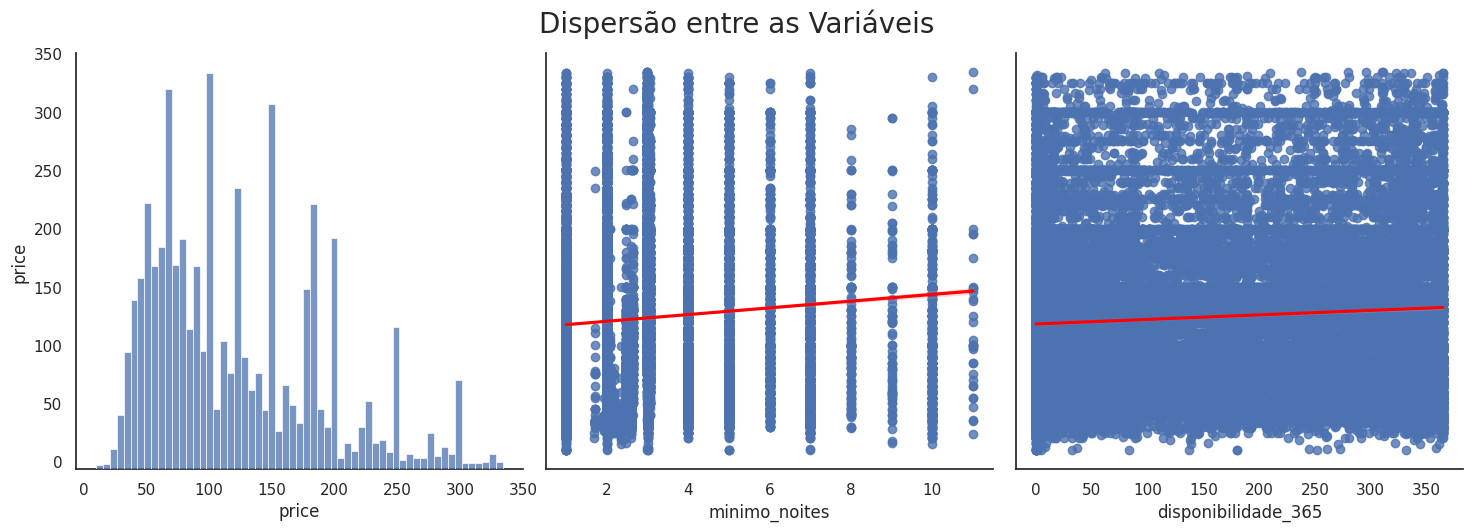

In [707]:
ax = sns.pairplot(df, y_vars='price', x_vars=['price','minimo_noites','disponibilidade_365'], height=5,kind='reg', plot_kws={'line_kws':{'color':'red'}})
ax.fig.suptitle('Dispersão entre as Variáveis', fontsize=20, y=1.05)
ax

Como podemos observar tanto o número mínimo de noites, quanto a disponibilidade apresentam uma correlação linear positiva, 0.07 e 0.08 respectivamente, com nossa variável Preço. Apesar dessa correlação positiva, essa relação é extramente fraca, não apresentando um impacto significativo em nossa variável resposta. Essa baixa correlação também é evidente em uma rápida análise gráfica. Lembrando que estamos apenas avaliando um relação linear.


### c. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

In [708]:
df['price'].describe()

count    48883.000000
mean       122.544516
std         67.236831
min         10.000000
25%         69.000000
50%        104.000000
75%        170.000000
max        334.000000
Name: price, dtype: float64

In [709]:
# Extraindo o primeiro e terceiro Quartil
Q1 = df['price'].quantile(.25)
Q3 = df['price'].quantile(.75)

# Cálculo da distância interquartil
IQR = Q3 - Q1

# Cálculo do Limite Superior
limite_superior = Q3 + IQR * 1,5

# Definindo as Quebras
bins   = [0,69,170,df['price'].max()]
labels = ['Baixo','Moderado','Alto']

# Criando colunas com as faixas de valores
df['faixa_price'] = pd.cut(df['price'],bins=bins,include_lowest=True,labels=labels)
df['faixa_price'].value_counts()

Moderado    24531
Baixo       12392
Alto        11960
Name: faixa_price, dtype: int64

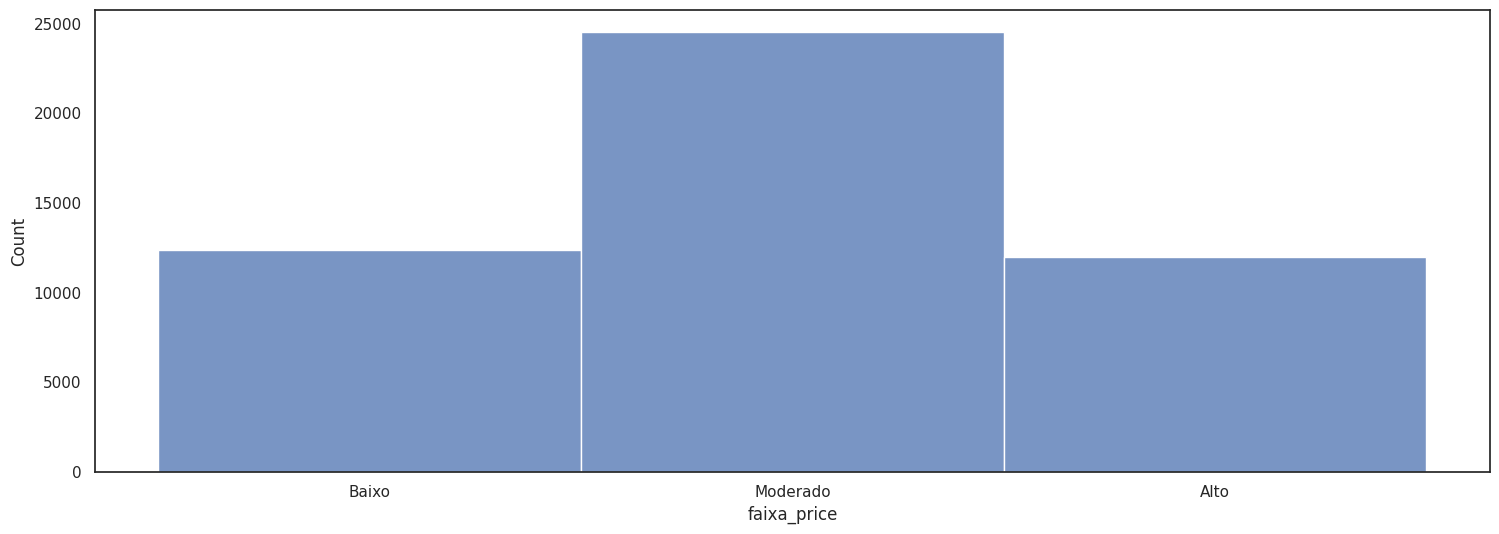

In [710]:
ax = sns.histplot(df['faixa_price'])
ax.figure.set_size_inches(18,6)

In [711]:
pd.crosstab(df['bairro_group'],df['faixa_price'])

faixa_price,Baixo,Moderado,Alto
bairro_group,,,
Bronx,578,465,47
Brooklyn,6565,10653,2876
Manhattan,2513,10625,8522
Queens,2574,2613,479
Staten Island,162,175,36


In [712]:
pd.crosstab(df['bairro_group'],df['faixa_price'],normalize='columns')*100

faixa_price,Baixo,Moderado,Alto
bairro_group,,,
Bronx,4.664300,1.895561,0.392977
Brooklyn,52.977728,43.426685,24.046823
Manhattan,20.279212,43.312543,71.254181
Queens,20.771465,10.651828,4.005017
Staten Island,1.307295,0.713383,0.301003


In [713]:
aux = aux[aux['faixa_price']=='Alto']

# Ajustando o tamanho dos pontos com base no preço para melhor visualização
aux['size'] = aux['price'] / aux['price'].max() * 300
aux['size'] = aux['size'].apply(lambda x: max(x, 5))  # Garantindo um tamanho mínimo para visibilidade

# Criando o mapa
fig = px.scatter_mapbox(aux,
                        lat="latitude",
                        lon="longitude",
                        color="faixa_price",  # Cor diferenciada por tipo de quarto
                        size="size",  # Tamanho do ponto baseado no preço ajustado
                        color_continuous_scale=px.colors.cyclical.IceFire,  # Escala de cor
                        size_max=15,
                        zoom=10,
                        hover_data=['price','bairro_group'],
                        mapbox_style="carto-positron",
                        title="Distribuição das acomodações de Alto Valor")
fig.update_layout(height = 600,width=1200, margin = {'r':0, 't':0, 'l':0, 'b':0})
fig.show()

Podemos observar que Manhattan detem aproximadamente 71,25% de todas as acomodações classificadas com um Alto valor, seguido por Brooklyn que concentra 24,04% destas acomodações. Está distribuição de imóveis fica evidente ao também analisarmos o mapa.

# Construção do Modelo Preditivo

In [714]:
df_model = df.copy()

## Tratamento das variáveis

In [715]:
df_model.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,size,faixa_price
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.000000,2019-05-21,0.380000,2.0,355.0,202.095808,Alto
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.000000,NaT,1.150691,1.0,365.0,134.730539,Moderado
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,10.941651,2019-07-05,4.640000,1.0,194.0,79.940120,Moderado
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.000000,2018-11-19,0.100000,1.0,0.0,71.856287,Moderado
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,8.309136,2019-06-22,0.590000,1.0,129.0,179.640719,Alto


### Criando variável de classificação dias desde o último review

In [716]:
# Verificando o último review disponivel na nossa base
df_model['ultima_review'].max()

Timestamp('2019-07-08 00:00:00')

In [717]:
df_model['dias_ultimo_review'] = pd.to_datetime('2019-07-08') - df_model['ultima_review']
df_model['dias_ultimo_review'] = df_model['dias_ultimo_review'].dt.days

In [718]:
df_model['dias_ultimo_review'].describe()

count    38832.000000
mean       276.948187
std        413.953551
min          0.000000
25%         15.000000
50%         50.000000
75%        365.000000
max       3024.000000
Name: dias_ultimo_review, dtype: float64

In [719]:
# Definindo faixas de review
bins = [-1,15,50,365,5000]
labels = ['recente','moderado','longo','muito_longo']

# Criando a coluna de faixa de review
df_model['faixa_review'] = pd.cut(df_model['dias_ultimo_review'],bins=bins,labels=labels)

df_model['faixa_review'] = df_model['faixa_review'].astype(str)

# Criando a classificação sem_review
df_model.loc[df_model['faixa_review']=='nan','faixa_review'] = 'sem_review'

In [720]:
df_model['faixa_review'].value_counts()

recente        10427
sem_review     10051
muito_longo     9688
longo           9525
moderado        9192
Name: faixa_review, dtype: int64

### Criando encodings para as variáveis categóricas

#### Label Enconder para a variável bairro

In [721]:
# Criando o Label Encoder
le_bairro = LabelEncoder()

In [722]:
df_model['bairro_encoding'] = le_bairro.fit_transform(df_model['bairro'])

In [723]:
df_model.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,size,faixa_price,dias_ultimo_review,faixa_review,bairro_encoding
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45.000000,2019-05-21,0.380000,2.0,355.0,202.095808,Alto,48.0,moderado,127
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3.0,0.000000,NaT,1.150691,1.0,365.0,134.730539,Moderado,NaN,sem_review,94
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,10.941651,2019-07-05,4.640000,1.0,194.0,79.940120,Moderado,3.0,recente,41
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9.000000,2018-11-19,0.100000,1.0,0.0,71.856287,Moderado,231.0,longo,61
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200.0,3.0,8.309136,2019-06-22,0.590000,1.0,129.0,179.640719,Alto,16.0,moderado,137


In [724]:
# Salvando o LabelEncoder ajustado com pickle
with open('/content/drive/MyDrive/Projeto Indicium/label_encoder_bairro.pkl', 'wb') as file:
    pickle.dump(le_bairro, file)

In [725]:
df_model.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365', 'size',
       'faixa_price', 'dias_ultimo_review', 'faixa_review', 'bairro_encoding'],
      dtype='object')

#### One hot encoding - room_type, bairro_group e faixa_review

In [726]:
df_model = pd.get_dummies(df_model, columns=['room_type','bairro_group','faixa_review'])

In [727]:
# Convertendo os nomes das colunas para uma lista
lista_colunas = df_model.columns.tolist()

# Salvando a lista de colunas como JSON
with open('/content/drive/MyDrive/Projeto Indicium/one_hot_columns.json', 'w') as file:
    json.dump(lista_colunas, file)

## Pré-seleção das variáveis para treinamento do modelo

In [728]:
y = df_model['price']

In [729]:
df_model.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro', 'latitude', 'longitude',
       'price', 'minimo_noites', 'numero_de_reviews', 'ultima_review',
       'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'size', 'faixa_price', 'dias_ultimo_review',
       'bairro_encoding', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'bairro_group_Bronx',
       'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'faixa_review_longo', 'faixa_review_moderado',
       'faixa_review_muito_longo', 'faixa_review_recente',
       'faixa_review_sem_review'],
      dtype='object')

In [730]:
X = df_model[['minimo_noites',
              'numero_de_reviews',
              'reviews_por_mes',
              'calculado_host_listings_count',
              'disponibilidade_365',
              'bairro_encoding',
              'room_type_Entire home/apt',
              'room_type_Private room',
              'room_type_Shared room',
              'bairro_group_Bronx',
              'bairro_group_Brooklyn',
              'bairro_group_Manhattan',
              'bairro_group_Queens',
              'bairro_group_Staten Island',
              'faixa_review_longo',
              'faixa_review_moderado',
              'faixa_review_muito_longo',
              'faixa_review_recente',
              'faixa_review_sem_review']]

## Separação da Base de treino e teste

In [731]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1997)

In [732]:
X_train.shape

(34218, 19)

In [733]:
X_test.shape

(14665, 19)

In [734]:
y_train.shape

(34218,)

In [735]:
y_test.shape

(14665,)

## Selecionando as variáveis utilizando o Boruta

In [736]:
X_train_n = X_train.values

In [737]:
y_train_n = y_train.values.ravel()

In [738]:
# Inicializando o regressor RandomForest
rf = RandomForestRegressor(n_jobs=-1, max_depth=5, random_state=1)

# Inicializando o Boruta
boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# Ajustando o Boruta ao conjunto de dados
boruta_feature_selector.fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	19
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	8


BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=123,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7F23515DFD40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F23515DFD40, verbose=2)

In [739]:
# Supondo que 'nomes_das_colunas' seja a lista com os nomes de todas as suas características originais
colunas_selecionadas = np.array(X_train.columns)[boruta_feature_selector.support_].tolist()
colunas_selecionadas

['minimo_noites',
 'numero_de_reviews',
 'reviews_por_mes',
 'calculado_host_listings_count',
 'disponibilidade_365',
 'bairro_encoding',
 'room_type_Entire home/apt',
 'room_type_Private room',
 'room_type_Shared room',
 'bairro_group_Brooklyn',
 'bairro_group_Manhattan']

In [740]:
X_train = X_train[colunas_selecionadas]
X_test = X_test[colunas_selecionadas]

## Treinando alguns modelos

### Regressão Linear

In [741]:
modelo_linear = LinearRegression()
modelo_linear.fit(X_train,y_train)

LinearRegression()

In [742]:
y_pred_linear= modelo_linear.predict(X_test)

In [743]:
# Calculando as métricas
mse_lr = mean_squared_error(y_test, y_pred_linear)
mae_lr = mean_absolute_error(y_test, y_pred_linear)
rmse_lr = mse_lr**0.5  # A raiz quadrada do MSE dá o RMSE

# Exibindo os resultados
print(f"MSE: {mse_lr}")
print(f"MAE: {mae_lr}")
print(f"RMSE: {rmse_lr}")

MSE: 2362.7054051185382
MAE: 35.43221420664521
RMSE: 48.60766817199256


### Ridge Regression

In [744]:
# Inicializando e treinando o modelo de regressão Ridge com um parâmetro alpha específico
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_ridge = model_ridge.predict(X_test)

# Calculando as métricas
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = mse_ridge**0.5

# Exibindo os resultados
print(f"Ridge MSE: {mse_ridge}")
print(f"Ridge MAE: {mae_ridge}")
print(f"Ridge RMSE: {rmse_ridge}")

Ridge MSE: 2362.7147323889258
Ridge MAE: 35.432547708537676
Ridge RMSE: 48.607764116331516


### Lasso Regression

In [745]:
# Inicializando e treinando o modelo de regressão Lasso com um parâmetro alpha específico
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_lasso = model_lasso.predict(X_test)

# Calculando as métricas
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = mse_lasso**0.5

# Exibindo os resultados
print(f"Lasso MSE: {mse_lasso}")
print(f"Lasso MAE: {mae_lasso}")
print(f"Lasso RMSE: {rmse_lasso}")

Lasso MSE: 2364.4941314809325
Lasso MAE: 35.46228021968905
Lasso RMSE: 48.62606432234602


### Random Forest Regressor

In [746]:
# Inicializando e treinando o modelo de Random Forest Regressor
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_rf = model_rf.predict(X_test)

# Calculando as métricas
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mse_rf**0.5

# Exibindo os resultados
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest MAE: {mae_rf}")
print(f"Random Forest RMSE: {rmse_rf}")

Random Forest MSE: 2190.4867679705985
Random Forest MAE: 33.82650051979171
Random Forest RMSE: 46.80263633568732


### XGBoost Regressor

In [747]:
# Inicializando e treinando o modelo XGBRegressor
model_xgb = XGBRegressor(objective='reg:squarederror',
                         n_estimators= 100,
                         max_depth = 10,
                         subsample = 0.7,
                         colsample_bytree = 0.9,
                         random_state=42)

model_xgb.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred_xgb = model_xgb.predict(X_test)

# Calculando as métricas
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb**0.5  # A raiz quadrada do MSE dá o RMSE

# Exibindo os resultados
print(f"XGBoost MSE: {mse_xgb}")
print(f"XGBoost MAE: {mae_xgb}")
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost MSE: 2381.3816952561738
XGBoost MAE: 35.45429016261941
XGBoost RMSE: 48.799402611673166


## Comparação dos modelos

In [748]:
# Criando um dicionário com as métricas
metricas = {
    'Modelo': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Random Forest Regressor', 'XGBoost Regressor'],
    'MSE': [mse_lr, mse_ridge, mse_lasso, mse_rf, mse_xgb],
    'MAE': [mae_lr, mae_ridge, mae_lasso, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso, rmse_rf, rmse_xgb]
}

# Convertendo o dicionário em um DataFrame
comparacao = pd.DataFrame(metricas)


In [749]:
# Exibindo o DataFrame para comparação
comparacao

,Modelo,MSE,MAE,RMSE
0,Linear Regression,2362.705405,35.432214,48.607668
1,Ridge Regression,2362.714732,35.432548,48.607764
2,Lasso Regression,2364.494131,35.462280,48.626064
3,Random Forest Regressor,2190.486768,33.826501,46.802636
4,XGBoost Regressor,2381.381695,35.454290,48.799403


Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?

R: Inicialmente, optamos pelo modelo de regressão como a solução mais adequada para o problema em questão. As variáveis para o modelo foram escolhidas através de um algoritmo que determinou as mais relevantes para uma análise de regressão. Antes dessa seleção, as variáveis categóricas foram submetidas a um processo de codificação, permitindo assim seu uso no treinamento do modelo. Escolhemos prosseguir com o Random Forest Regressor devido às suas excelentes métricas de desempenho, incluindo MSE, MAE e RMSE, que são padrão para avaliar problemas de regressão. O Random Forest Regressor se destaca por sua robustez e precisão, sendo eficaz em uma ampla gama de cenários de regressão. Ele minimiza o overfitting através do uso de múltiplas árvores de decisão e mostra flexibilidade com variados tipos de dados. No entanto, sua complexidade de treinamento e interpretação, juntamente com a demanda por recursos computacionais e de memória, são considerações importantes.

## Salvando o modelo

In [750]:
# Salvando o Random Forest Regressor ajustado com pickle
with open('/content/drive/MyDrive/Projeto Indicium/model_rf.pkl', 'wb') as file:
    pickle.dump(model_rf, file)

# Aplicando o modelo aos novos dados

In [773]:
# Função para coletar dados do usuário
def preco_sugerido():
  import pandas as pd
  import numpy as np

  label_enconder = open('/content/drive/MyDrive/Projeto Indicium/label_encoder_bairro.pkl','rb')
  label_encoder_bairro = pickle.load(label_enconder)
  label_enconder.close()

  modelo = open('/content/drive/MyDrive/Projeto Indicium/model_rf.pkl','rb')
  model_rf = pickle.load(modelo)
  modelo.close()

  # dados = {
  #       'id': int(input("Digite o id: ")),
  #       'nome': input("Digite o nome: "),
  #       'host_id': int(input("Digite o host_id: ")),
  #       'host_name': input("Digite o host_name: "),
  #       'bairro_group': input("Digite o bairro_group: "),
  #       'bairro': input("Digite o bairro: "),
  #       'latitude': float(input("Digite a latitude: ")),
  #       'longitude': float(input("Digite a longitude: ")),
  #       'room_type': input("Digite o room_type: "),
  #       'price': int(input("Digite o price: ")),
  #       'minimo_noites': int(input("Digite o minimo_noites: ")),
  #       'numero_de_reviews': int(input("Digite o numero_de_reviews: ")),
  #       'ultima_review': input("Digite a ultima_review (AAAA-MM-DD): "),
  #       'reviews_por_mes': float(input("Digite o reviews_por_mes: ")),
  #       'calculado_host_listings_count': int(input("Digite o calculado_host_listings_count: ")),
  #       'disponibilidade_365': int(input("Digite o disponibilidade_365: "))
  #   }

  dados = {
        'bairro_group': input("Digite o bairro_group: "),
        'bairro': input("Digite o bairro: "),
        'room_type': input("Digite o room_type: "),
        'minimo_noites': int(input("Digite o minimo_noites: ")),
        'numero_de_reviews': int(input("Digite o numero_de_reviews: ")),
        'ultima_review': input("Digite a ultima_review (AAAA-MM-DD): "),
        'reviews_por_mes': float(input("Digite o reviews_por_mes: ")),
        'calculado_host_listings_count': int(input("Digite o calculado_host_listings_count: ")),
        'disponibilidade_365': int(input("Digite o disponibilidade_365: "))
    }

  df = pd.DataFrame([dados])

  df['ultima_review'] = pd.to_datetime(df['ultima_review'])

  df['dias_ultimo_review'] = pd.to_datetime('2019-07-08') - df['ultima_review']
  df['dias_ultimo_review'] = df['dias_ultimo_review'].dt.days

  bins = [-1,15,50,365,5000]
  labels = ['recente','moderado','longo','muito_longo']

  df['faixa_review'] = pd.cut(df['dias_ultimo_review'],bins=bins,labels=labels)
  df['faixa_review'] = df['faixa_review'].astype(str)

  df.loc[df['faixa_review']=='nan','faixa_review'] = 'sem_review'


  df['bairro_encoding'] = label_encoder_bairro.fit_transform(df['bairro'])

  df = pd.get_dummies(df, columns=['room_type','bairro_group','faixa_review'])

  # Caminho para o seu arquivo JSON
  caminho_json = '/content/drive/MyDrive/Projeto Indicium/one_hot_columns.json'

  # Carregar as colunas do arquivo JSON
  with open(caminho_json, 'r') as file:
    estrutura_json = json.load(file)
    colunas_desejadas = estrutura_json

  # Reindexar o DataFrame para corresponder à ordem das colunas do JSON
  df = df.reindex(columns=colunas_desejadas)

  df.replace(np.nan,0,inplace=True)

  df_final = df[['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
                 'calculado_host_listings_count', 'disponibilidade_365',
                 'bairro_encoding', 'room_type_Entire home/apt',
                 'room_type_Private room', 'room_type_Shared room',
                 'bairro_group_Brooklyn', 'bairro_group_Manhattan']]

  print('------------------------------------------------------------')
  print('------------------------------------------------------------')
  print('O preço final sugerido para o Apartamento é: R$', model_rf.predict(df_final)[0].round(2))

In [775]:
preco_sugerido()

Digite o bairro_group: Manhattan
Digite o bairro: Midtown
Digite o room_type: Entire home/apt
Digite o minimo_noites: 1
Digite o numero_de_reviews: 45
Digite a ultima_review (AAAA-MM-DD): 2019-05-21
Digite o reviews_por_mes: 0.38
Digite o calculado_host_listings_count: 2
Digite o disponibilidade_365: 355
------------------------------------------------------------
------------------------------------------------------------
O preço final sugerido para o Apartamento é: R$ 205.12
